Este colab fue desarrollado por Arnold Charry Armero.

# Modelo (Q, R) - Enfoque de Optimización

El Modelo (Q, R) toma en cuenta la variabilidad tanto de la demanda como del tiempo de entrega $\tau$ para seleccionar el tamaño de lote $Q$ y el punto de reorden $R$ que satisfagan el objetivo trazado. En el enfoque de optimización, lo más importante consiste en minimizar los costos relacionados con la cantidad a ordenar y el punto de reorden. Es importante destacar que existen faltantes, pero estos están en función del punto de reorden $R$.

**Supuestos:**

*   Existe uno o varios productos en el sistema de inventarios
*   La demanda es estocástica
*   Se permiten faltantes
*   Hay un tiempo de entrega estocástico
*   Toda la cantidad ordenada llega al mismo tiempo.

Para calcular la demanda promedio (esperada) durante el tiempo de entrega y su respectiva desviación estándar, se emplean las siguientes ecuaciones,

$$ \bar{D_{\tau}} = \bar{D}\mu_{L} $$

$$ \sigma_{\tau }=\sqrt{\mu_{L}\sigma^{2}+\bar{D}^{2}\sigma_{L}^{2}} $$

Sabiendo que el punto de reorden se calcula como,

$$ R = \bar{D_{\tau}} + s $$

Adicionalmente, se toma en cuenta la función de densidad de probabilidad que permite evaluar el nivel de servicio,

$$ L(z) = \int_{z}^{\infty}\left ( x -z \right ) \phi \left ( x \right ) dx $$

Que para el caso de la Distribución Normal se puede escribir como,

$$ L(z) = \frac{1}{\sqrt{2\pi }}z \int_{-\infty}^{z} e^{\frac{-t^{2}}{2}}\:dt  + \frac{1}{\sqrt{2\pi }}e^{\frac{-z^{2}}{2}} - z$$

Matemáticamente, el modelo se define de la siguiente manera,

$$ K(Q, \:R) = \frac{A\bar{D}}{Q} + c\bar{D}  + h \left (\frac{Q}{2} + R + \bar{D_{\tau}} \right ) + \frac{\pi \bar{D} \bar{b}(R)}{Q}  $$

donde,

$ Q = \mathrm{Cantidad \:de \: lote \: a \: ordenar} $

$ R = \mathrm{Punto \:de \: reorden} $

$ b = \mathrm{Cantidad \:de \: faltantes \: a \: permitir} $

$ c = \mathrm{Costo \: unitario \: de \: producción} $

$ D = \mathrm{Tasa \:de \: demanda} $

$ A = \mathrm{Costo \:unitario \: de \: ordenar} $

$ \pi = \mathrm{Costo \:unitario \: de \: faltantes} $

$ \bar{D_{\tau}} = \mathrm{Media \: de \: la \: demanda \: durante \: el \: tiempo \: de \:entrega} $

$ \sigma_{\tau } = \mathrm{Desviación \: estándar \:de \: la \: demanda \: durante \: el \:tiempo \: de \: entrega} $

$ h = \mathrm{Costo \:unitario \: de \: mantener \: en \: inventario} $

$ K = \mathrm{Costo \: total \: promedio} $

$$ \frac{\partial K}{\partial Q} = 0, \frac{\partial K}{\partial R} = 0 $$

Simplificando y despejando $Q$,

$$ Q^{*} = \sqrt{\frac{2D \left [ A + \pi\bar{b}(R) \right ]}{h}} $$

Y para hallar $R$,

$$ F(z) =  1 - \frac{hQ}{\pi \bar{D}}$$

De $F(z)$ se halla $z$ para calcular $R$,

$$ R = \bar{D_{\tau}} + z \sigma_{\tau } $$

Se calcula el nivel máximo de órdenes atrasadas,

$$ \bar{b}(R) = \sigma_{\tau } L(z)$$



Y se vuelven a calcular $Q\:$ y $R\:$  hasta que coincidan con el valor obtenido anteriormente.

Estas formulas nos indican cuánto se debe ordenar y cuál es el punto de reorden con el fin de minimizar los costos de inventario. Para efectos de practicidad, se utilizará Python para resolver ejercicios. Ahora se continua con la implementación en código resolviendo el siguiente ejemplo.

**Ejemplo 6-27. Modelo (Q, R): enfoque de optimización.** Super-P es una compañía procesadora
de cacahuates. La experiencia indica que la demanda anual tiene distribución normal con D = 25 000
tons y la desviación estándar de 36 tons. Para ordenar los cacahuates, la compañía gasta $\$50$ para
procesar la orden. Cada tonelada de cacahuates cuesta $ \$1000 $ y la tasa de interés anual para evaluar el
costo del inventario es 25%. La sanción por un faltante se estima en $\$4$ por ton. El tiempo para colocar
una orden es aproximadamente una semana. Calcule la cantidad económica a ordenar y el punto
de reorden usando el enfoque de optimización.

In [1]:
#Se importan las librerias
import scipy as sp
from scipy.integrate import quad
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Se definen los parámetros.
D_bar = 25000
sigma = 36
mu_L = (1/52)
sigma_L = 0
A = 50
c = 1000
i = 0.25
h = i * c
pi = 4

In [7]:
#Se hallan los valores de Demanda y desviación estándar
D_tau = D_bar * mu_L
sigma_tau = np.sqrt(mu_L * sigma**2 + D_bar**2 * sigma_L**2)
print(f"La demanda durante el tiempo de entrega es {D_tau}")
print(f"La desviación estándar durante el tiempo de entrega es {sigma_tau}")

La demanda durante el tiempo de entrega es 480.7692307692308
La desviación estándar durante el tiempo de entrega es 4.9923017660270625


In [8]:
#Se define la ecuación de Q
def optimal_Q(A, D_bar, h, pi, b):
  return np.sqrt((2 * D_bar * (A + pi * b)) / h)

In [9]:
#Se define L(z)
def Phi1(t):
  return (1/np.sqrt(2*np.pi))* np.exp((-1/2)*t**2)

def L(z):
  Phi = quad(Phi1, -np.inf, z)[0]
  return z*Phi + (1/np.sqrt(2*np.pi))* np.exp((-1/2)*z**2) - z

In [28]:
#Se crea el bucle
q = [np.inf, 0]
r = [np.inf, 0]
j = 1
b = 0
cont = 0

while round(q[j], 2) != round(q[j-1], 2) or round(r[j], 2) != round(r[j-1], 2):
  Q = optimal_Q(A, D_bar, h, pi, b)
  q.append(Q)
  f_z = 1 - (h * Q) / (pi * D_bar)
  z = st.norm.ppf(f_z)
  R = D_tau + z * sigma_tau
  r.append(R)
  b = sigma_tau * L(z)
  j += 1
  cont += 1
else:
  Q = round(q[j])
  R = round(r[j])
  print(f"El valor óptimo de Q es {Q} unidades")
  print(f"El punto de reorden de R es {R} unidades")

El valor óptimo de Q es 103 unidades
El punto de reorden de R es 484 unidades


In [48]:
#Se define la función
def K(Q, R):
  """
  Calcula el costo del modelo (Q, R)
  con enfoque de optimización

  Args:
    Q: Cantidad de lote a ordenar
    R: Punto de reorden

  Returns:
    K: Costo Total Promedio
  """
  return (A*D_bar)/ Q + c*D_bar + h*(Q/2 + R + D_tau) + (pi * D_bar * b) / Q

In [50]:
print(f"El costo total esperado con {Q} unidades de lote\ny {R} unidades de reorden es de ${K(Q, R)}")

El costo total esperado con 103 unidades de lote
y 484 unidades de reorden es de $25266955.47218247


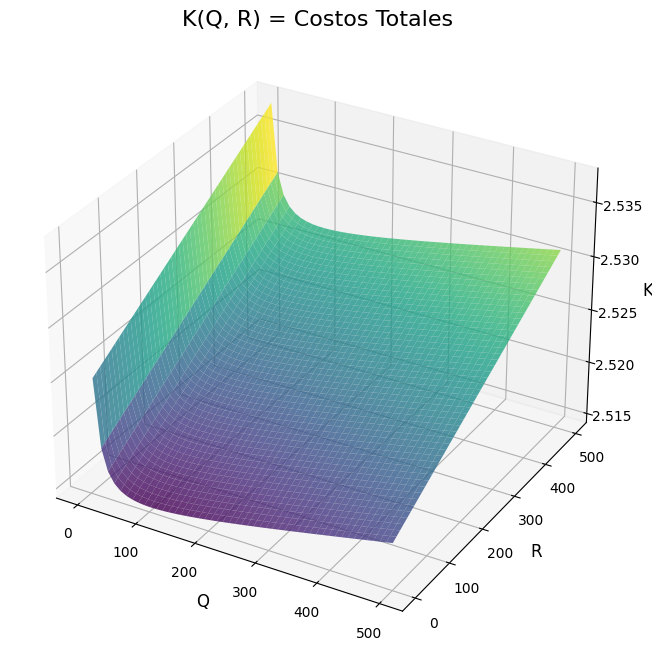

In [51]:
#Se grafica la función
x = np.linspace(0, 500)
y = np.linspace(0, 500)

X, Y = np.meshgrid(x, y)
Z = K(X, Y)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

ax.set_title('K(Q, R) = Costos Totales', fontsize=16)
ax.set_xlabel('Q', fontsize=12)
ax.set_ylabel('R', fontsize=12)
ax.set_zlabel('K', fontsize=12)

plt.show()

Así queda concluido el Modelo (Q, R) con enfoque de optimización.

*   Pulido, H. G. (2007). Control estadístico de calidad y Seis Sigma.
*   Lind, D. A., Marchal, W. G., & Wathen, S. A. (2005). Estadística aplicada a los negocios y a la economía.
*   Sipper, D., & Bulfin, R. L. (1998). Planeación y control de la producción.
*   Zill, D. G. (2011). Cálculo de varias variables (4a. ed.).